# 加上两个用户行为特征

1. lb8699基础上
2. 添加他的新特征



In [ ]:
import sys
sys.path.append("..")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
%run ../util/base_frame.py

#train_df = pd.read_table('../../round2_train.txt', sep=' ')
#train_df = pd.read_table('../../round1_ijcai_18_train_20180301.txt',sep=' ')
#test_df = pd.read_table('../../round1_ijcai_18_test_a_20180301.txt',sep=' ')
test_df = pd.read_table('../../round2_ijcai_18_test_a_20180425.txt',sep=' ')
print(train_df.shape,test_df.shape)

In [63]:
from contextlib import contextmanager
import time
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name} done in {time.time() - start_time:.2f} s]')

In [ ]:
##################
# 首先根据交易率抽样
df_list = []
for val in train_df.is_trade.unique():
    df = train_df[train_df.is_trade == val].sample(frac=0.05)
    df_list.append(df)
sample_train_df = pd.concat(df_list, ignore_index=True)
import gc
del train_df
del test_df
gc.collect()

In [146]:
%run ../util/base_frame.py
with timer("load data into base frame"):
    fa = BaseFrame(sample_train_df, test_df, 6, True)

[0 7 6 2 4 1 3 5]
[load data into base frame done in 7.05 s]


# 1 先处理时序数据, 基本标签化处理

In [147]:
# 时间处理: 分离天, 星期几, 上中下午/晚上, 小时数
# date最终不使用，直接用day(第 0 - 7 天)

from sklearn import preprocessing
from datetime import datetime
le = preprocessing.LabelEncoder()

fa.df['weekday'] = fa.df['context_timestamp'].apply(lambda x: datetime.fromtimestamp(x).weekday())
fa.df['hour'] = fa.df['context_timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
fa.df['minute'] = fa.df['context_timestamp'].apply(lambda x: datetime.fromtimestamp(x).minute)
fa.df['seconds'] = fa.df['context_timestamp'].apply(lambda x: datetime.fromtimestamp(x).second)
print(fa.df.shape)

(1041489, 35)


In [148]:
# 标签化
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()

for col in ['item_id', 'item_brand_id', 'item_city_id', 'shop_id', 'user_id']:
    fa.df[col] = lbl.fit_transform(fa.df[col])
print(fa.df.shape)

(1041489, 35)


# 2 特征处理

### 时间交易频次特征

In [149]:
def groupbySizeFeat(df, feats, name):
    target = df.groupby(feats).size().reset_index().rename(columns={0: name})
    return pd.merge(df, target, 'left', on=feats)

with timer("groupby size feat"):
    fa.df = groupbySizeFeat(fa.df, ['user_id', 'day'], 'user_query_day')
    fa.df = groupbySizeFeat(fa.df, ['user_id', 'weekday'], 'user_query_weekday')
    fa.df = groupbySizeFeat(fa.df, ['user_id', 'day', 'hour'], 'user_query_day_hour')
    fa.df = groupbySizeFeat(fa.df, ['day', 'user_id', 'item_id'], 'day_user_item_id')
    fa.df = groupbySizeFeat(fa.df, ['day', 'hour', 'minute', 'user_id', 'item_id'], 'day_hour_minute_user_item_id')
    fa.df = groupbySizeFeat(fa.df, ['day', 'hour', 'item_id'], 'number_day_hour_item_id')
    fa.df = groupbySizeFeat(fa.df, ['item_id', 'user_id'], 'item_user_id')
    fa.df = groupbySizeFeat(fa.df, ['item_category_list', 'item_city_id'], 'item_category_city_id')
    fa.df = groupbySizeFeat(fa.df, ['item_category_list', 'item_sales_level'], 'item_category_sales_level')
    fa.df = groupbySizeFeat(fa.df, ['item_category_list', 'item_price_level'], 'item_category_price_level')

    fa.df = groupbySizeFeat(fa.df, ['item_id', 'item_sales_level'], 'item_ID_sales_level')
    fa.df = groupbySizeFeat(fa.df, ['item_id', 'item_collected_level'], 'item_ID_collected_level')
    fa.df = groupbySizeFeat(fa.df, ['user_id'], 'number_user_id')
    fa.df = groupbySizeFeat(fa.df, ['shop_id'], 'number_shop_id')
print(fa.df.shape)

[groupby size feat done in 54.68 s]
(1041489, 49)


### last access， next access

In [150]:
import collections

m = collections.defaultdict(dict)
def get_user_t_series(x):
    m[x["user_id"]][x["instance_id"]] = x["context_timestamp"]
    return 0

def get_last_access_minute(x):
    arr = m[x["user_id"]]
    max_idx = len(arr)-1
    target_idx = -1
    for idx,v in enumerate(arr):
        if v[0] == x["instance_id"]:
            target_idx = idx
    
    if target_idx == max_idx:
        return np.nan
    else:
        return int((arr[target_idx][1] - arr[target_idx+1][1]) / 60)

def get_next_access_minute(x):
    arr = m[x["user_id"]]
    max_idx = len(arr)-1
    target_idx = -1
    for idx,v in enumerate(arr):
        if v[0] == x["instance_id"]:
            target_idx = idx
    
    if target_idx - 1 < 0:
        return np.nan
    else:
        return int((arr[target_idx-1][1] - arr[target_idx][1]) / 60)

fa.df.apply(get_user_t_series, axis=1)

for k,v in m.items():
    m[k] = sorted(v.items(),key = lambda x:x[1], reverse = True)

fa.df["next_access_min"] = fa.df.apply(get_next_access_minute, axis=1)
fa.df["last_access_min"] = fa.df.apply(get_last_access_minute, axis=1)
print(fa.df.shape)

(1041489, 51)


### 类目特征OneHotEncoding

In [151]:
for i in range(5):
    fa.df['predict_category_property' + str(i)] = lbl.fit_transform(fa.df['predict_category_property'].map(
        lambda x: str(str(x).split(';')[i]) if len(str(x).split(';')) > i else ''))

for i in range(1, 3):
    fa.df['item_category_list' + str(i)] = lbl.fit_transform(fa.df['item_category_list'].map(
        lambda x: str(str(x).split(';')[i]) if len(str(x).split(';')) > i else ''))  # item_category

for i in range(10):
    fa.df['item_property_list' + str(i)] = lbl.fit_transform(fa.df['item_property_list'].map(
        lambda x: str(str(x).split(';')[i]) if len(str(x).split(';')) > i else ''))


In [152]:
fa.df['gender0'] = fa.df['user_gender_id'].apply(lambda x: x + 1 if x == -1 else x)
fa.df['age0'] = fa.df['user_age_level'].apply(lambda x: 1003 if x == -1  else x)
fa.df['occupation0'] = fa.df['user_occupation_id'].apply(lambda x: 2005 if x == -1  else x)
fa.df['star0'] = fa.df['user_star_level'].apply(lambda x: 3006 if x == -1 else x)

In [153]:
fa.df = groupbySizeFeat(fa.df, ['item_brand_id', 'shop_review_positive_rate'], 'number_item_brand_positive_rate')
fa.df = groupbySizeFeat(fa.df, ['item_brand_id', 'shop_star_level'], 'number_item_brand_shop_star')
fa.df = groupbySizeFeat(fa.df, ['item_city_id', 'item_pv_level'], 'number_item_city_pv_level')
fa.df = groupbySizeFeat(fa.df, ['item_city_id', 'user_id'], 'number_item_city_user_id')
fa.df = groupbySizeFeat(fa.df, ['item_price_level', 'item_sales_level'], 'number_item_price_sales_level')
fa.df = groupbySizeFeat(fa.df, ['predict_category_property', 'item_sales_level'], 'number_predict_category_sales_level')
fa.df = groupbySizeFeat(fa.df, ['item_collected_level', 'shop_id'], 'number_collected_shop_id')


### 访问频次
>比如说user_id, shop_id group: user访问shop的第几次

In [154]:
# %run ../util/time_utils.py


# fa.df['last_1_user_shop'] = getLastImpressTime(fa.df, ['user_id', 'shop_id'])
# fa.df['last_1_user_item'] = getLastImpressTime(fa.df, ['user_id', 'item_id'])
# fa.df['last_1_user_shop_item'] = getLastImpressTime(fa.df, ['user_id', 'shop_id', 'item_id'])
# print(fa.df.shape)

In [155]:
# %run ../util/time_utils.py

# fa.df['next_1_user_shop'] = getNextImpressTime(fa.df, ['user_id', 'shop_id'])
# fa.df['next_1_user_item'] = getNextImpressTime(fa.df, ['user_id', 'item_id'])
# fa.df['next_1_user_shop_item'] = getNextImpressTime(fa.df, ['user_id', 'shop_id', 'item_id'])

### 重复列特征

In [156]:
%run ../util/time_utils.py
dup_feat = ['item_id', 'user_id']
with timer("duplicate feat"):
    fa.df = generateColDupByDay(fa.df, dup_feat, list(range(1, 8)), verbose=False)
print(fa.df.shape)

[duplicate feat done in 80.00 s]
(1041489, 93)


### 交易率特征选择

*固定smooth为10*

1. 特征是否独立提升?
2. 平滑是否不会改变正负向?

##### 正向特征

> item_city_id, shop_id, user_gender_id, item_sales_level, item_collected_level, shop_review_num_level

##### 负向特征

> item_price_level,
item_id,item_brand_id,item_pv_level,user_age_level,
user_occupation_id,user_star_level,context_page_id,
shop_review_positive_rate,shop_star_level,
shop_score_service,shop_score_description,day,hour


In [157]:
# 计算前一天的交易率set到下一天，第0天用回自己
%run ../util/trade_info.py

trade_rela = ['item_id', 'item_brand_id', 'shop_id', 'user_id']

generateTradeRateByDate(fa.df, trade_rela, 7, None, verbose=False, glbSmoothing=200, glbMean0=0.05)
print(fa.df.shape)

C:\Anaconda3\lib\site-packages\pandas\core\series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


(1041489, 102)


### 复合交易率

In [158]:
fa.df.columns

Index(['context_id', 'context_page_id', 'context_timestamp', 'data_set',
       'day1', 'instance_id', 'is_trade', 'item_brand_id',
       'item_category_list', 'item_city_id',
       ...
       'user_id_dup_gg_7', '_key1', 'exp_d_item_id_7', 'cnt_d_item_id_7',
       'exp_d_item_brand_id_7', 'cnt_d_item_brand_id_7', 'exp_d_shop_id_7',
       'cnt_d_shop_id_7', 'exp_d_user_id_7', 'cnt_d_user_id_7'],
      dtype='object', length=102)

In [159]:
%run  ../util/trade_info.py

with timer("multi trade rate"):
    fa.df['u2i_sz'], fa.df['u2i_sum'], fa.df['u2i_rate'] = getMultiTradeRate(fa.df, ['user_id', 'item_id'])
    fa.df['u2shop_sz'], fa.df['u2shop_sum'], fa.df['u2shop_rate'] = getMultiTradeRate(fa.df, ['user_id', 'shop_id'])
    fa.df['u2brand_sz'], fa.df['u2brand_sum'], fa.df['u2brand_rate'] = getMultiTradeRate(fa.df, ['user_id', 'item_brand_id'])
    fa.df['u2page_sz'], fa.df['u2page_sum'], fa.df['u2page_rate'] = getMultiTradeRate(fa.df, ['user_id', 'context_page_id'])
    fa.df['u2hour_sz'], fa.df['u2hour_sum'], fa.df['u2hour_rate'] = getMultiTradeRate(fa.df, ['user_id', 'hour'])
    fa.df['u2sstar_sz'], fa.df['u2sstar_sum'], fa.df['u2sstar_rate'] = getMultiTradeRate(fa.df, ['user_id', 'shop_star_level'])
print(fa.df.shape)

data before day 0 is setted, with period 7, data size 59792
data before day 1 is setted, with period 7, data size 66976
data before day 2 is setted, with period 7, data size 64249
data before day 3 is setted, with period 7, data size 61811
data before day 4 is setted, with period 7, data size 58102
data before day 5 is setted, with period 7, data size 60002
data before day 6 is setted, with period 7, data size 97062
data before day 7 is setted, with period 7, data size 573495
data before day 0 is setted, with period 7, data size 59792
data before day 1 is setted, with period 7, data size 66976
data before day 2 is setted, with period 7, data size 64249
data before day 3 is setted, with period 7, data size 61811
data before day 4 is setted, with period 7, data size 58102
data before day 5 is setted, with period 7, data size 60002
data before day 6 is setted, with period 7, data size 97062
data before day 7 is setted, with period 7, data size 573495
data before day 0 is setted, with peri

### 复合类型拆解

In [160]:
fa.df.columns.values

array(['context_id', 'context_page_id', 'context_timestamp', 'data_set',
       'day1', 'instance_id', 'is_trade', 'item_brand_id',
       'item_category_list', 'item_city_id', 'item_collected_level',
       'item_id', 'item_price_level', 'item_property_list',
       'item_pv_level', 'item_sales_level', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_score_delivery', 'shop_score_description',
       'shop_score_service', 'shop_star_level', 'user_age_level',
       'user_gender_id', 'user_id', 'user_occupation_id',
       'user_star_level', 'date', 'day', 'weekday', 'hour', 'minute',
       'seconds', 'user_query_day', 'user_query_weekday',
       'user_query_day_hour', 'day_user_item_id',
       'day_hour_minute_user_item_id', 'number_day_hour_item_id',
       'item_user_id', 'item_category_city_id',
       'item_category_sales_level', 'item_category_price_level',
       'item_ID_sales_level', 'item_ID_collected_level', 

In [161]:
%run ../util/complex_type.py
from sklearn import preprocessing
from datetime import datetime
le = preprocessing.LabelEncoder()
fa.df = process_complex_types_v2(fa.df, get_icl_map(fa.df), get_ipl_map(fa.df))

fa.df['item_category_1'] = le.fit_transform(fa.df.item_category_1)
fa.df['item_category_2'] = le.fit_transform(fa.df.item_category_2)
print(fa.df.shape)

get_icl_map ... 
get_ipl_map ... 
processing predict_category_property ...
processing item_property_list ...
processing item_category_list ...
generating item_category_1, item_category_2 ...
(1041489, 129)


In [162]:
# fa.df['context_timestamp'] = fa.df.context_timestamp_x
# del fa.df['context_timestamp_y']
# del fa.df['context_timestamp_x']
#del fa.df['context_timestamp_y']

In [163]:
%run ../util/complex_type.py

cnt_user_item_review = fa.df[["user_id", "item_id", "instance_id"]].groupby(["user_id", "item_id"])['instance_id'].count().to_dict() 
cnt_user_cate_review = fa.df[["user_id", "item_category_1", "instance_id"]].groupby(["user_id", "item_category_1"])['instance_id'].count().to_dict()  

f1 = set_review_cnt("user_id", "item_id", cnt_user_item_review)
f2 = set_review_cnt("user_id", "item_category_1", cnt_user_cate_review)

tmp = fa.df.sort_values(by="context_timestamp")
tmp["item_review_cnt"] = tmp[["user_id", "item_id"]].apply(f1, axis=1)
tmp["cate_review_cnt"] = tmp[["user_id", "item_category_1"]].apply(f2, axis=1)
fa.df = tmp.sort_index()

print(fa.df.shape)

(1041489, 131)


# 3 fitXgb训练

In [164]:
import xgboost
from sklearn.model_selection import ParameterGrid
#import lightgbm as lgb
%run ../util/base_frame.py



non_feat_columns = ['context_timestamp', 'instance_id', 'is_trade', 'context_id',
                   'item_property_list', 'item_category_list',  'predict_category_property','tmp','day1'
                   ]

# cnt_d_shop_id 单特征变差，全集变好
neg_feat_columns = ['exp_d_user_id_7', 'cnt_d_item_id_7', 'cnt_d_item_brand_id_7']



params = {
    'max_depth':[3],
    'n_estimators':[3000],
    'min_child_weight':[5],
    'gamma':[5]
}


m = None
with timer("training"):
    if sum(fa.y_test == -1) == 0:
        # 进入测试阶段
        xgb = xgboost.XGBClassifier(n_jobs=7)
        for g in ParameterGrid(params):
            xgb.set_params(**g)
            print('>', '- '*40, '\n\n> ', g, '\n')
    #         fa.fit(xgb, pos_feat_columns, '11', drop=False)
            fa.fit(xgb, non_feat_columns+neg_feat_columns, '14', drop=True, early_stopping_rounds=150)
            print(xgb.best_score)
            # fa.fit(xgb, non_feat_columns+['exp_d_user_id', 'cnt_d_item_brand_id'], '11', drop=True)
    else:
        # 进入提交阶段
        xgb = xgboost.XGBClassifier(**{'gamma': 5, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 222, 'n_jobs': 7})
        fa.fit(xgb, non_feat_columns+neg_feat_columns, '20_4633_3414', drop=True, early_stopping_rounds=150)


X_train (521601, 117), y_train (521601,), X_test (519888, 117), y_test (519888,)
> (521601, 117) 

[training done in 246.81 s]


In [165]:
fa.y_test

0        -1
1        -1
2        -1
3        -1
4        -1
5        -1
6        -1
7        -1
8        -1
9        -1
10       -1
11       -1
12       -1
13       -1
14       -1
15       -1
16       -1
17       -1
18       -1
19       -1
20       -1
21       -1
22       -1
23       -1
24       -1
25       -1
26       -1
27       -1
28       -1
29       -1
         ..
519858   -1
519859   -1
519860   -1
519861   -1
519862   -1
519863   -1
519864   -1
519865   -1
519866   -1
519867   -1
519868   -1
519869   -1
519870   -1
519871   -1
519872   -1
519873   -1
519874   -1
519875   -1
519876   -1
519877   -1
519878   -1
519879   -1
519880   -1
519881   -1
519882   -1
519883   -1
519884   -1
519885   -1
519886   -1
519887   -1
Name: is_trade, Length: 519888, dtype: int64

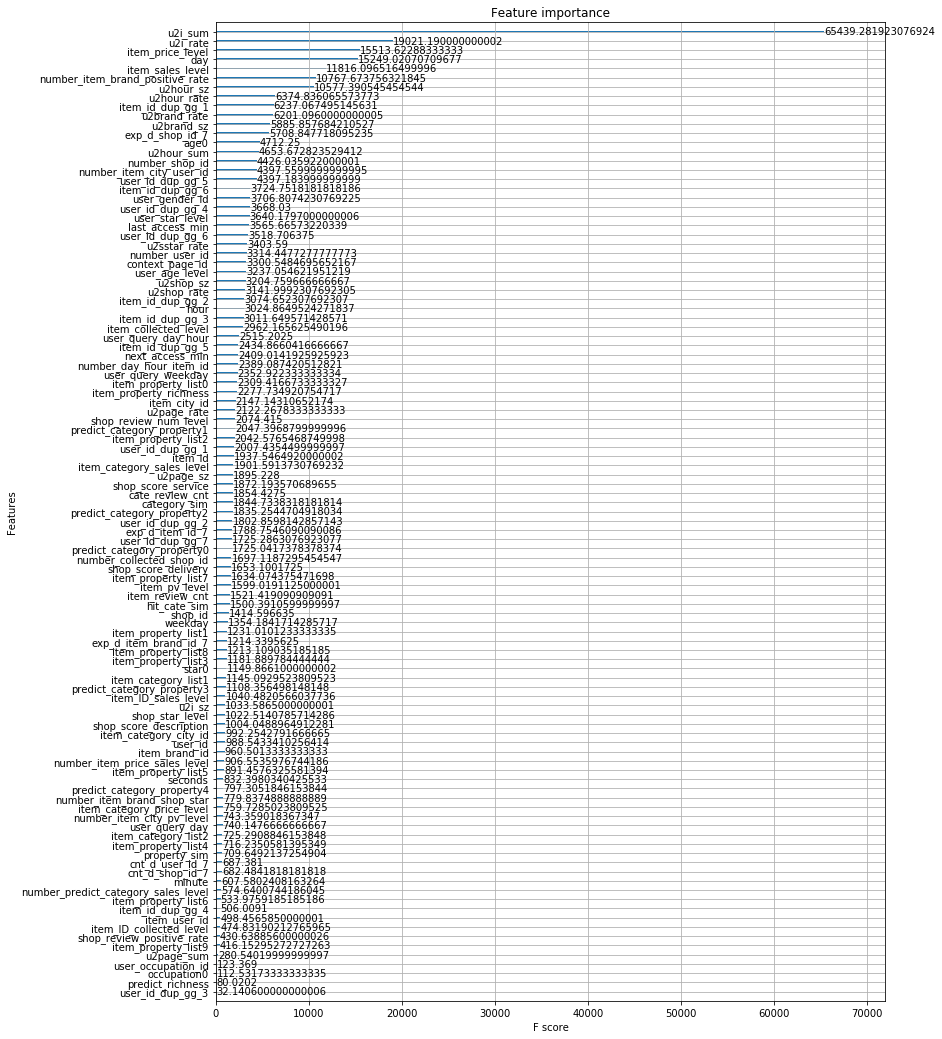

In [166]:
fig,ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(xgb, ax=ax, importance_type='cover')
plt.show()

In [167]:
import tensorflow